Found 1843 files belonging to 2 classes.
Found 235 files belonging to 2 classes.
Found 437 files belonging to 2 classes.
74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.5825 - loss: 0.7423
Epoch 1: val_loss improved from inf to 0.69979, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 505s 8s/step - accuracy: 0.5830 - loss: 0.7414 - val_accuracy: 0.5447 - val_loss: 0.6998
Epoch 2/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.6961 - loss: 0.5630
Epoch 2: val_loss improved from 0.69979 to 0.49175, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 32s 201ms/step - accuracy: 0.6965 - loss: 0.5625 - val_accuracy: 0.7617 - val_loss: 0.4917
Epoch 3/50
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step - accuracy: 0.7801 - loss: 0.4709
Epoch 3: val_loss improved from 0.49175 to 0.45804, saving model to best_model.keras
58/58 ━━━━━━━━━━━━━━━━━━━━ 12s 205ms/step - accuracy: 0.7802 - loss: 0.4708 - val_accura

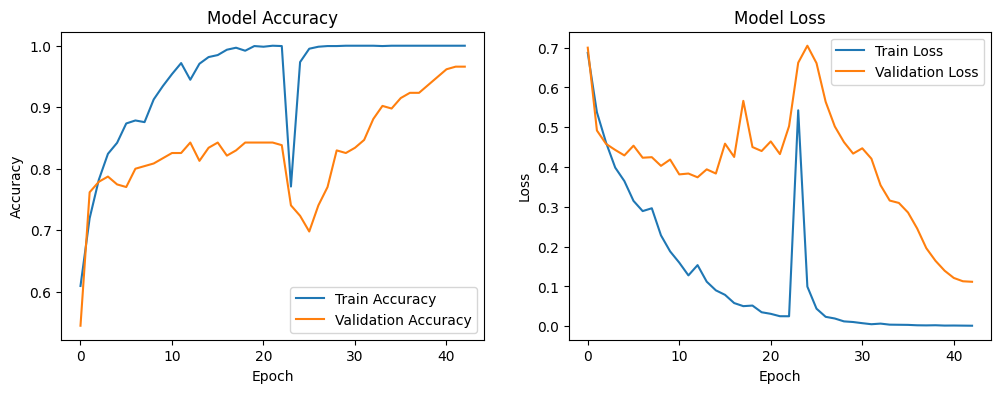

In [ ]:
# Install required libraries
!pip install tensorflow
!pip install matplotlib

# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Define directories for the dataset
train_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train'
validation_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation'
test_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test'

# Set image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalize the pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Load DenseNet model without the top classification layer
base_model = tf.keras.applications.DenseNet201(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define checkpoint and early stopping
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for early stopping
    min_delta=0.001,  # Smaller improvement to continue training
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

# Fine-tuning: Unfreeze some layers of the base model after initial training
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training for fine-tuning
fine_tune_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy after fine-tuning: {test_accuracy:.2f}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Get the true labels and predicted labels from the test dataset
y_true = []
y_pred = []

# Iterate through the test dataset and collect predictions and true labels
for images, labels in test_dataset:
    # Predict the probabilities for each image batch
    predictions = model.predict(images)
    # Convert probabilities to binary predictions (0 or 1)
    predicted_labels = np.where(predictions > 0.5, 1, 0).flatten()

    # Store the true labels and predicted labels
    y_true.extend(labels.numpy())
    y_pred.extend(predicted_labels)

# Calculate the F1 score
f1 = f1_score(y_true, y_pred, average='weighted')
print(f"F1 Score: {f1:.2f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 16s 16s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 98ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 15s 15s/step
F1 Score: 0.93


In [ ]:
# Import necessary libraries
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

# Generate predictions for the test set
y_true = []
y_pred = []

# Iterate through the test dataset to get true labels and predictions
for images, labels in test_dataset:
    predictions = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((predictions > 0.5).astype(int).flatten())

# Calculate precision, recall, f1-score, and support
precision, recall, f1_score, support = precision_recall_fscore_support(y_true, y_pred, average='binary')

# Calculate the average accuracy
accuracy = accuracy_score(y_true, y_pred)

# Print the results
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1_score:.4f}')
print(f'Support: {support}' )
print(f'Average Accuracy: {accuracy:.4f}')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 206ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
Precision: 0.8205
Recall: 0.9846
F1 Score: 0.8951
Support: None
Average Accuracy: 0.9314


In [ ]:
# Save the model to your Google Drive
model.save('/content/drive/MyDrive/brain_stroke_classification_model.keras')


In [ ]:
# Install required libraries
!pip install tensorflow
!pip install matplotlib

# Import libraries
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import matplotlib.pyplot as plt

# Define directories for the dataset
train_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Train'
validation_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Validation'
test_dir = '/content/drive/MyDrive/Brain_Stroke_CT-SCAN_image/Test'

# Set image size and batch size
img_height, img_width = 224, 224
batch_size = 32

# Load datasets
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    validation_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

# Normalize the pixel values to [0, 1]
normalization_layer = layers.Rescaling(1./255)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))
test_dataset = test_dataset.map(lambda x, y: (normalization_layer(x), y))

# Load DenseNet model without the top classification layer
base_model = tf.keras.applications.DenseNet201(
    input_shape=(img_height, img_width, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the base model
base_model.trainable = False

# Create a new model on top
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Define checkpoint and early stopping
checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,  # Increased patience for early stopping
    min_delta=0.001,  # Smaller improvement to continue training
    restore_best_weights=True,
    verbose=1
)

# Train the model
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50,
    callbacks=[checkpoint, early_stopping]
)

# Fine-tuning: Unfreeze some layers of the base model after initial training
base_model.trainable = True

# Recompile with a lower learning rate for fine-tuning
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Continue training for fine-tuning
fine_tune_history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=20,
    callbacks=[checkpoint, early_stopping]
)

# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy after fine-tuning: {test_accuracy:.2f}")

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'] + fine_tune_history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'] + fine_tune_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'] + fine_tune_history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'] + fine_tune_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()

plt.show()
